In [1]:
# install.packages('packcircles', version = '0.3.6')

In [2]:
library(packcircles)
library(ggplot2)
# library(ggrepel) library(dplyr)

FIGURE_FOLDER = '../figures/'
DATA_FOLDER = '../data/'

# Read in UniProt/Swiss-Prot (Sprot) data

In [3]:
library("arrow")
swissprot_data <- read_parquet(paste0(DATA_FOLDER, "uniprot_sprot_taxonomy_summary_with_domains.parquet"))
head(swissprot_data)


Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp




organism,reviewed_count,unreviewed_count,pdb_structures_count,organism_id,lineage,type,type_merge_microbes,superdomain,domain,kingdom
<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Homo sapiens,20417,0,8511,9606,Catarrhini; Chordata; Craniata; Euarchontoglires; Eukaryota; Euteleostomi; Eutheria; Haplorrhini; Hominidae; Homo; Mammalia; Metazoa; Primates; Vertebrata,Animal,Animal,Cellular Life,Eukaryota,Animal
Mus musculus,17228,0,2458,10090,Chordata; Craniata; Euarchontoglires; Eukaryota; Euteleostomi; Eutheria; Glires; Mammalia; Metazoa; Muridae; Murinae; Muroidea; Mus; Myomorpha; Rodentia; Vertebrata,Animal,Animal,Cellular Life,Eukaryota,Animal
Arabidopsis thaliana,16396,0,1057,3702,Arabidopsis; Brassicaceae; Brassicales; Camelineae; Embryophyta; Eukaryota; Gunneridae; Magnoliopsida; Pentapetalae; Spermatophyta; Streptophyta; Tracheophyta; Viridiplantae; eudicotyledons; malvids; rosids,Plant,Plant,Cellular Life,Eukaryota,Plant
Rattus norvegicus,8209,0,724,10116,Chordata; Craniata; Euarchontoglires; Eukaryota; Euteleostomi; Eutheria; Glires; Mammalia; Metazoa; Muridae; Murinae; Muroidea; Myomorpha; Rattus; Rodentia; Vertebrata,Animal,Animal,Cellular Life,Eukaryota,Animal
Saccharomyces cerevisiae (strain ATCC 204508 / S288c),6733,0,2114,559292,Ascomycota; Dikarya; Eukaryota; Fungi; Saccharomyces; Saccharomycetaceae; Saccharomycetales; Saccharomycetes; Saccharomycotina,Fungi,Fungi,Cellular Life,Eukaryota,Fungi
Bos taurus,6048,0,560,9913,Artiodactyla; Bos; Bovidae; Bovinae; Chordata; Craniata; Eukaryota; Euteleostomi; Eutheria; Laurasiatheria; Mammalia; Metazoa; Pecora; Ruminantia; Vertebrata,Animal,Animal,Cellular Life,Eukaryota,Animal


## Make `plot_circles` a function using code from Arcadia

Code from: https://github.com/Arcadia-Science/2024-protein-universe/tree/v1.0/code

In [4]:
# Set up color dicitionary for plots
seanome_colors <- c("#1e3d6b", "#206E82", "#45B1A8", "#18495A", "#89C2BA", "#D4E6E4", "#2D7A8F", "#C4A5B5", "#BFA065", "#8B7A9F")



plot_circles <- function(
    value_col, 
    domain_col, 
    species_col, 
    domains_to_use = c("Archaea", "Bacteria", "Eukaryota"), 
    show_top5 = FALSE) 
{
  data <- data.frame(species = species_col, value = value_col, domain = domain_col)
  print(names(data))
  print(nrow(data))
  print(head(data$value))

  # Make sure to only use nonzero values
  data <- data[data$value > 0, ]

  data <- data[data$domain %in% domains_to_use, ]
  data <- data[order(data$domain), ]
  print(nrow(data))
  print(head(data$value))

  packing <- circleProgressiveLayout(data$value, sizetype = "area")
  data <- cbind(data, packing)
  dat.gg <- circleLayoutVertices(packing, npoints = 50)
  dat.gg$value <- rep(data$value, each = 51)
  dat.gg$domain <- rep(data$domain, each = 51)



  cols <- seanome_colors[5:7]
  names(cols) <- domains_to_use
  cols <- cols[match(data$domain, names(cols))]

  p <- ggplot() +

  # Make the bubbles
  geom_polygon(
    data = dat.gg, aes(x,
      y,
      group = id,
      fill = as.factor(domain)
    ),
    # linewidth = 0.2,
    # colour = "black"
  ) +
  scale_fill_manual(values = cols) +
  scale_size_continuous(range = c(1, 4)) +

  # General theme:
  theme_void() +
  theme(legend.position = "none") +
  coord_equal()

  if (show_top5) {
    p <- p + # Label top 5 largest groups p <- p + # Label top 5 largest groups
    geom_text(data = head(data[order(-data$value), ], 5), aes(x, y, label = species))
  }


  return(p)
}


wrap_plot_labeled_unlabeled_circles_save_png = function(
    numbers_to_plot, 
    domains, 
    organisms, 
    figure_prefix
) {
    plot1 = plot_circles(numbers_to_plot, domains, organisms)
    png1 = paste0(FIGURE_FOLDER, figure_prefix, ".png")
    ggsave(png1, plot1)
    plot1

    # Same thing, but top 5 are labeled
    plot2 = plot_circles(numbers_to_plot, domains, organisms, show_top5 = TRUE)
    png2 = paste0(FIGURE_FOLDER, figure_prefix, "_labeled.png")
    ggsave(png2, plot2)
    plot2
}


# Protein Data Bank (PDB)
## Proteins in UniProt reviewed with PDB structures

[1] "species" "value"   "domain" 
[1] 14755
[1] 8511 2458 1057  724 2114  560
[1] 2617
[1] 224 123  55   7 174  16


Saving 7 x 7 in image


[1] "species" "value"   "domain" 
[1] 14755
[1] 8511 2458 1057  724 2114  560
[1] 2617
[1] 224 123  55   7 174  16


Saving 7 x 7 in image


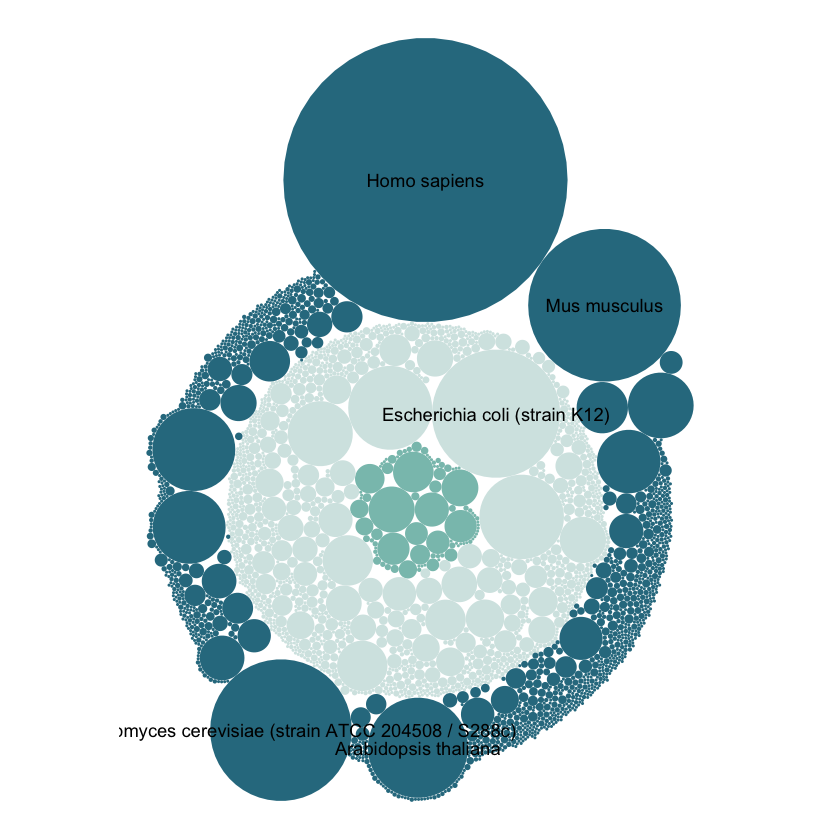

In [5]:
# p1a = plot_circles(swissprot_data$pdb_structures_count, uniprot_data$domain, uniprot_data$organism)
# ggsave("figures/01_packcircles_pdb.png", p1a)
# p1a
# p1b = plot_circles(uniprot_data$pdb_structures_count, uniprot_data$domain, uniprot_data$organism, show_top5 = TRUE)
# ggsave("figures/01_packcircles_pdb_labeled.png", p1b)
# p1b


wrap_plot_labeled_unlabeled_circles_save_png(
    swissprot_data$pdb_structures_count, 
    swissprot_data$domain, 
    swissprot_data$organism, 
    "00_packcircles_uniprot_swissprot_pdb"
)

## Proteins with structures in UniProt/SwissProt Reviewed + UniProt/TREMBL Unreveiewed)

In [6]:
uniprot_combined <- read_parquet(
    paste0(DATA_FOLDER, "uniprot_combined_sprot_trembl_taxonomy_summary.parquet")
)
nrow(uniprot_combined)
head(uniprot_combined)

[1] 1333054

organism,organism_id,lineage,type,type_merge_microbes,superdomain,domain,kingdom,pdb_structures_count,reviewed_count,unreviewed_count
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>
Homo sapiens,9606,Catarrhini; Chordata; Craniata; Euarchontoglires; Eukaryota; Euteleostomi; Eutheria; Haplorrhini; Hominidae; Homo; Mammalia; Metazoa; Primates; Vertebrata,Animal,Animal,Cellular Life,Eukaryota,Animal,8511,20417,0
Mus musculus,10090,Chordata; Craniata; Euarchontoglires; Eukaryota; Euteleostomi; Eutheria; Glires; Mammalia; Metazoa; Muridae; Murinae; Muroidea; Mus; Myomorpha; Rodentia; Vertebrata,Animal,Animal,Cellular Life,Eukaryota,Animal,2458,17228,0
Saccharomyces cerevisiae (strain ATCC 204508 / S288c),559292,Ascomycota; Dikarya; Eukaryota; Fungi; Saccharomyces; Saccharomycetaceae; Saccharomycetales; Saccharomycetes; Saccharomycotina,Fungi,Fungi,Cellular Life,Eukaryota,Fungi,2114,6733,0
Escherichia coli (strain K12),83333,Bacteria; Enterobacterales; Enterobacteriaceae; Escherichia; Gammaproteobacteria; Pseudomonadota,Bacteria,Microbial,Cellular Life,Bacteria,Monera,1732,4531,0
Arabidopsis thaliana,3702,Arabidopsis; Brassicaceae; Brassicales; Camelineae; Embryophyta; Eukaryota; Gunneridae; Magnoliopsida; Pentapetalae; Spermatophyta; Streptophyta; Tracheophyta; Viridiplantae; eudicotyledons; malvids; rosids,Plant,Plant,Cellular Life,Eukaryota,Plant,1057,16396,0
Bacillus subtilis (strain 168),224308,Bacillaceae; Bacillales; Bacillati; Bacilli; Bacillota; Bacillus; Bacteria,Bacteria,Microbial,Cellular Life,Bacteria,Monera,753,4191,0


[1] "species" "value"   "domain" 
[1] 1333054
[1] 8511 2458 2114 1732 1057  753
[1] 7215
[1] 224 174 143 123 110 110


Saving 7 x 7 in image


[1] "species" "value"   "domain" 
[1] 1333054
[1] 8511 2458 2114 1732 1057  753
[1] 7215
[1] 224 174 143 123 110 110


Saving 7 x 7 in image


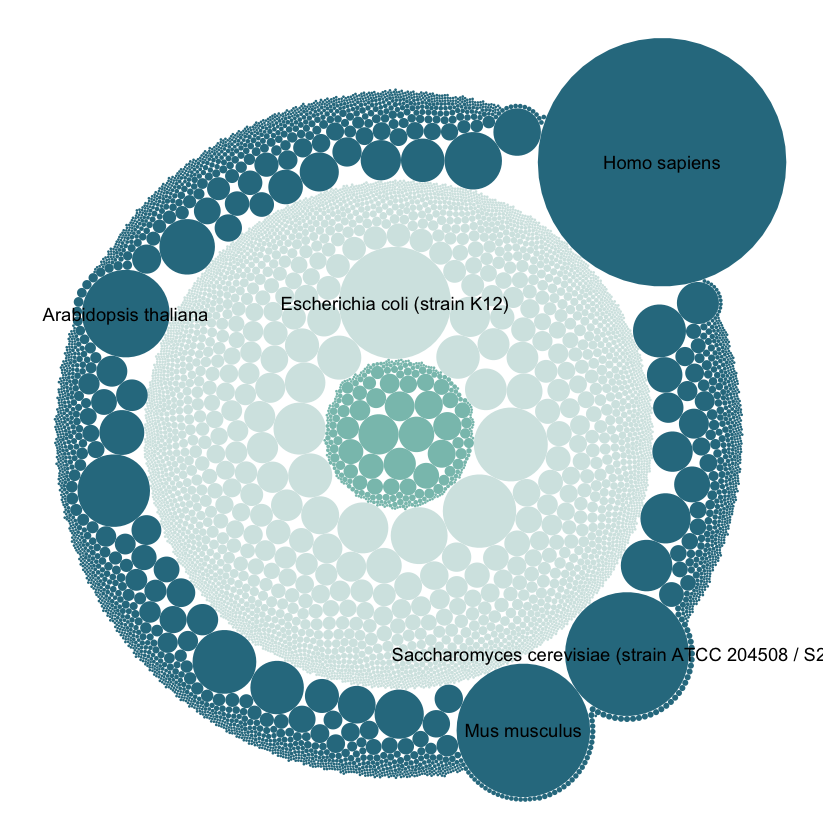

In [7]:


wrap_plot_labeled_unlabeled_circles_save_png(
    uniprot_combined$pdb_structures_count, 
    uniprot_combined$domain, 
    uniprot_combined$organism, 
    "01_packcircles_uniprot_combined_pdb"
)

# Plot Proteins in Uniprot Reviewed

[1] "species" "value"   "domain" 
[1] 1333054
[1] 20417 17228  6733  4531 16396  4191
[1] 11989
[1] 1787  509  497 1038  494  444


Saving 7 x 7 in image


[1] "species" "value"   "domain" 
[1] 1333054
[1] 20417 17228  6733  4531 16396  4191
[1] 11989
[1] 1787  509  497 1038  494  444


Saving 7 x 7 in image


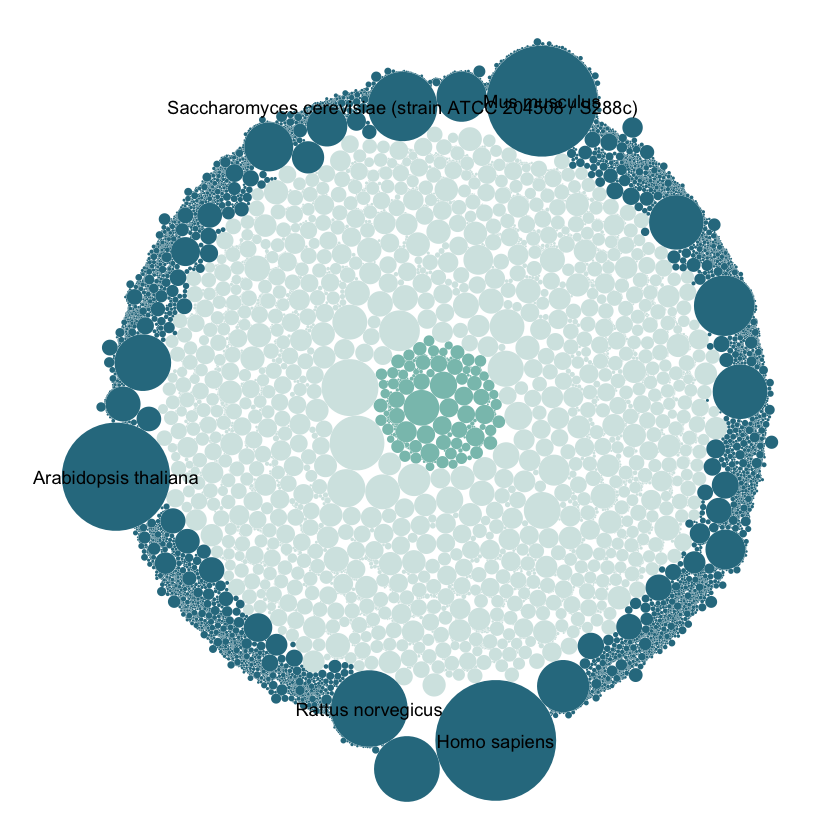

In [8]:
wrap_plot_labeled_unlabeled_circles_save_png(
    uniprot_combined$reviewed_count, 
    uniprot_combined$domain, 
    uniprot_combined$organism, 
    "02_packcircles_uniprot_swissprot_reviewed"
)

# Uniprot TREMBL (catalogued, equivalent to AFDB from Arcadia Science "Known Protein Universe" paper)

In [9]:
uniprot_trembl <- read_parquet(
    paste0(DATA_FOLDER, "uniprot_trembl_taxonomy_summary.parquet")
)
head(uniprot_trembl)

organism,organism_id,lineage,type,reviewed_count,unreviewed_count,pdb_structures_count,type_merge_microbes,superdomain,domain,kingdom
<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
Muscina sp. BIOUG31116-G08,2362392,Eukaryota; Metazoa; Ecdysozoa; Arthropoda; Hexapoda; Insecta; Pterygota; Neoptera; Endopterygota; Diptera; Brachycera; Muscomorpha; Muscoidea; Muscidae; Reinwardtiinae; Muscina,Animal,0,1,0,Animal,Cellular Life,Eukaryota,Animal
Billbergia distachya,1093647,Eukaryota; Viridiplantae; Streptophyta; Embryophyta; Tracheophyta; Spermatophyta; Magnoliopsida; Liliopsida; Poales; Bromeliaceae; Bromelioideae; Billbergia,Plant,0,4,0,Plant,Cellular Life,Eukaryota,Plant
Meteoridium tenuissimum,195109,Eukaryota; Viridiplantae; Streptophyta; Embryophyta; Bryophyta; Bryophytina; Bryopsida; Bryidae; Hypnanae; Hypnales; Brachytheciaceae; Meteoridium,Plant,0,3,0,Plant,Cellular Life,Eukaryota,Plant
Macropanesthia mackerrasae,112945,Eukaryota; Metazoa; Ecdysozoa; Arthropoda; Hexapoda; Insecta; Pterygota; Neoptera; Polyneoptera; Dictyoptera; Blattodea; Blaberoidea; Blaberidae; Geoscapheinae; Macropanesthia,Animal,0,15,0,Animal,Cellular Life,Eukaryota,Animal
Phassus sp. BOLD:AAI2895,1216432,Eukaryota; Metazoa; Ecdysozoa; Arthropoda; Hexapoda; Insecta; Pterygota; Neoptera; Endopterygota; Lepidoptera; Glossata; Exoporia; Hepialoidea; Hepialidae; Phassus,Animal,0,1,0,Animal,Cellular Life,Eukaryota,Animal
Brochothrix phage BL3,764562,Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes,Viruses,0,67,0,Microbial,Non-cellular Life,Viruses,Viruses


In [10]:
nrow(uniprot_trembl)

[1] 1318326

[1] "species" "value"   "domain" 
[1] 1333054
[1] 0 0 0 0 0 0
[1] 1109824
[1] 1586 3501 1356 2486 2424 1132


Saving 7 x 7 in image


[1] "species" "value"   "domain" 
[1] 1333054
[1] 0 0 0 0 0 0
[1] 1109824
[1] 1586 3501 1356 2486 2424 1132


Saving 7 x 7 in image


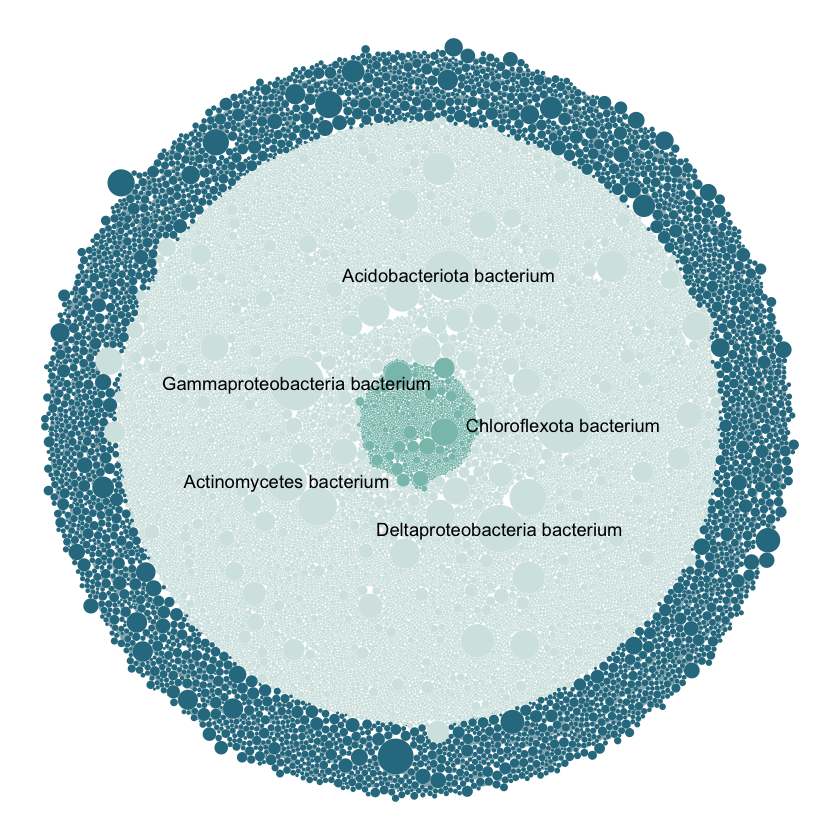

In [11]:
wrap_plot_labeled_unlabeled_circles_save_png(
    uniprot_combined$unreviewed_count, 
    uniprot_combined$domain, 
    uniprot_combined$organism, 
    "03_packcircles_uniprot_trembl_unreviewed"
)

# Total number of proteins predicted on earth

In [12]:
predicted_n_proteins <- read_parquet(
    paste0(DATA_FOLDER, "predicted_n_proteins_larsen2017.parquet")
)
head(predicted_n_proteins)

index,domain,kingdom,n_species,n_genes,n_ten_thousand_species,n_genes_per_ten_thousand,organism_number
<int>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<chr>
0,Archaea,Archaea,17460000,5000,1746,50000000,10k_Archaea_0000000000
1,Archaea,Archaea,17460000,5000,1746,50000000,10k_Archaea_0000000001
2,Archaea,Archaea,17460000,5000,1746,50000000,10k_Archaea_0000000002
3,Archaea,Archaea,17460000,5000,1746,50000000,10k_Archaea_0000000003
4,Archaea,Archaea,17460000,5000,1746,50000000,10k_Archaea_0000000004
5,Archaea,Archaea,17460000,5000,1746,50000000,10k_Archaea_0000000005


In [13]:
nrow(predicted_n_proteins)

[1] 223834

[1] "species" "value"   "domain" 
[1] 223834
[1] 50000000 50000000 50000000 50000000 50000000 50000000
[1] 223834
[1] 50000000 50000000 50000000 50000000 50000000 50000000


Saving 7 x 7 in image


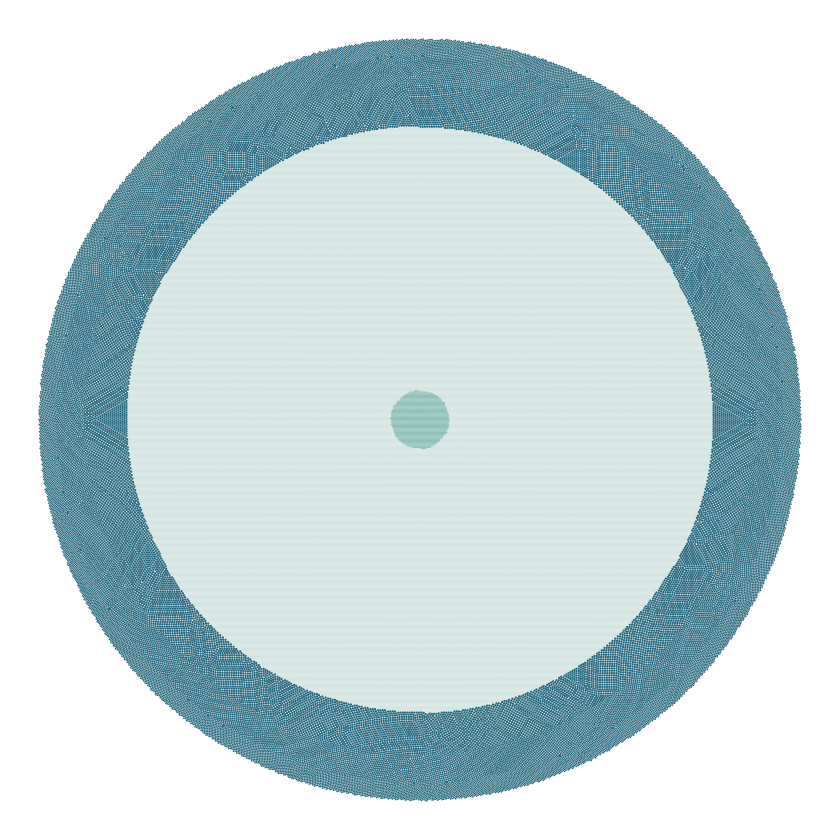

In [14]:

p4 = plot_circles(
    predicted_n_proteins$n_genes_per_ten_thousand, 
    predicted_n_proteins$domain, 
    predicted_n_proteins$organism_number
)
ggsave(paste0(FIGURE_FOLDER, "04_n_predicted_proteins.png"), p4)
p4